In [16]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from datasets import load_dataset

ds = load_dataset("gretelai/synthetic_text_to_sql")

Using the latest cached version of the dataset since gretelai/synthetic_text_to_sql couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/studio-lab-user/.cache/huggingface/datasets/gretelai___synthetic_text_to_sql/default/0.0.0/273a86f5f290e8d61b6767a9ff690c82bc990dc4 (last modified on Thu Dec 26 19:21:24 2024).


In [4]:
train_dataset = load_dataset("gretelai/synthetic_text_to_sql", split="train")
test_dataset  = load_dataset("gretelai/synthetic_text_to_sql", split="test")
train_dataset = train_dataset.to_pandas()
test_dataset = test_dataset.to_pandas()

Using the latest cached version of the dataset since gretelai/synthetic_text_to_sql couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/studio-lab-user/.cache/huggingface/datasets/gretelai___synthetic_text_to_sql/default/0.0.0/273a86f5f290e8d61b6767a9ff690c82bc990dc4 (last modified on Thu Dec 26 19:21:24 2024).
Using the latest cached version of the dataset since gretelai/synthetic_text_to_sql couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/studio-lab-user/.cache/huggingface/datasets/gretelai___synthetic_text_to_sql/default/0.0.0/273a86f5f290e8d61b6767a9ff690c82bc990dc4 (last modified on Thu Dec 26 19:21:24 2024).


In [5]:
train_dataset.head()

,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro..."
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...


Como el dataset es demasiado grande para el entrenamiento que voy a hacer posteriormente, me voy a quedar solo con unos pocos dominios. Los dominios presentes en el dataset se observan en la siguiente imagen, descargada desde la página del dataset presente en huggingface.

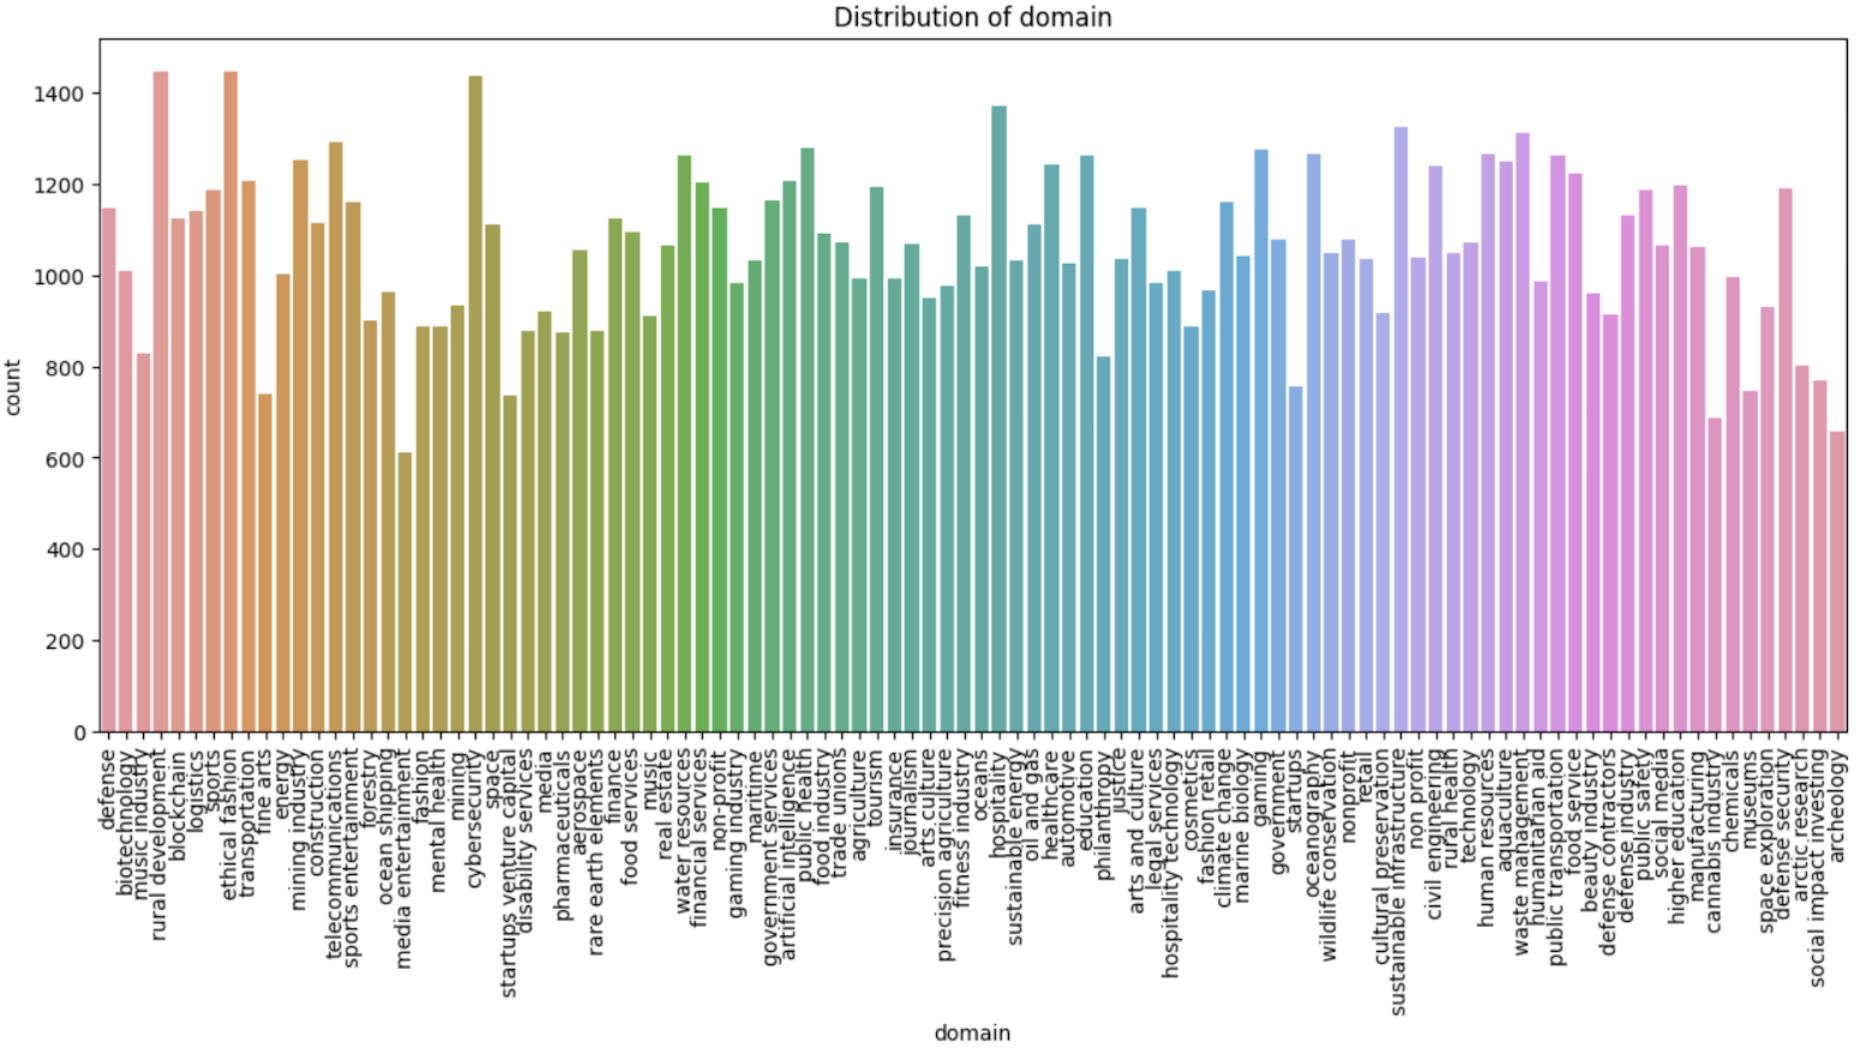

In [6]:
dominios = ['space exploration', 
            'sports', 
            'aerospace', 
            'insurance', 
            'public health', 
            'oceans', 
            'cybersecurity', 
            'hospitality',
            'nonprofit', 
            'oceanography',
            'hospitality technology',
            'rural development',
            'technology',
            'human resources'
           ]

train_dataset = train_dataset[train_dataset['domain'].isin(dominios)]
test_dataset = test_dataset[test_dataset['domain'].isin(dominios)]

train_dataset = train_dataset[['sql_prompt', 'sql', 'domain', 'sql_context']]
test_dataset = test_dataset[['sql_prompt', 'sql', 'domain', 'sql_context']]

# junto los dos datasets para hacer el preprocesamiento, luego al entrenar, vuelvo a dividir todo el dataset en entrenamiento y pruebas
frames = [train_dataset, test_dataset]
df = pd.concat(frames)
df.head()

,sql_prompt,sql,domain,sql_context
21,What are the unique combinations of security i...,"SELECT incident, status FROM incident_response...",cybersecurity,CREATE TABLE incident_responses (incident VARC...
27,Identify hotels with the highest virtual tour ...,"SELECT hotel_name, q1_2022_views FROM virtual_...",hospitality technology,"CREATE TABLE virtual_tour_stats (hotel_id INT,..."
28,What are the common cybersecurity policies acr...,SELECT policy FROM PolicyAnalysis GROUP BY pol...,cybersecurity,"CREATE TABLE PolicyAnalysis (id INT, policy VA..."
35,What is the total number of security incidents...,"SELECT region, SUM(incidents) as total_inciden...",cybersecurity,"CREATE TABLE incident_region(id INT, region VA..."
41,What is the average age of patients who receiv...,"SELECT v.county, AVG(p.age) as avg_age FROM va...",public health,"CREATE TABLE vaccinations (patient_id INT, cou..."


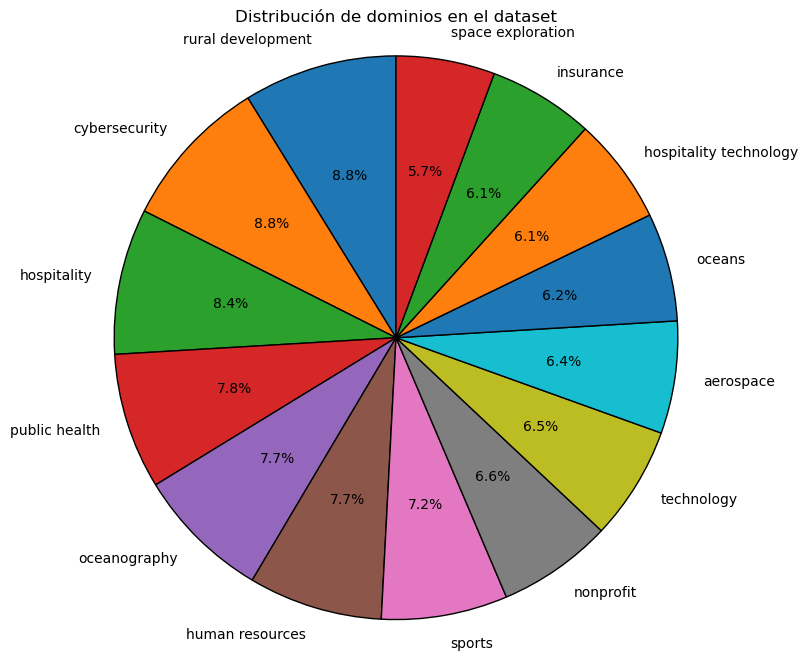

In [7]:
# voy a mirar si el dataset está desbalanceado; en el caso de que está, voy a tomar la decisión oportuna
import matplotlib.pyplot as plt

# Contamos las frecuencias de cada dominio
domain_counts = df['domain'].value_counts()

# Creamos una lista con los nombres de los dominios y sus respectivos porcentajes
labels = domain_counts.index
sizes = domain_counts.values
percentages = [f'{(size / sum(sizes)) * 100:.1f}%' for size in sizes]

# Crear el gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

# Título y diseño
plt.title('Distribución de dominios en el dataset')
plt.axis('equal')  # Asegura que la tarta sea un círculo

# Mostrar el gráfico
plt.show()

In [8]:
# Convertimos a minúsculas
df['sql_prompt'] = df['sql_prompt'].map(lambda x: x.lower())
# df['sql'] = df['sql'].map(lambda x: x.lower())

# Función para eliminar signos de puntuación
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la función al dataset
df['sql_prompt'] = df['sql_prompt'].map(eliminar_signos)
df.head()

,sql_prompt,sql,domain,sql_context
21,what are the unique combinations of security i...,"SELECT incident, status FROM incident_response...",cybersecurity,CREATE TABLE incident_responses (incident VARC...
27,identify hotels with the highest virtual tour ...,"SELECT hotel_name, q1_2022_views FROM virtual_...",hospitality technology,"CREATE TABLE virtual_tour_stats (hotel_id INT,..."
28,what are the common cybersecurity policies acr...,SELECT policy FROM PolicyAnalysis GROUP BY pol...,cybersecurity,"CREATE TABLE PolicyAnalysis (id INT, policy VA..."
35,what is the total number of security incidents...,"SELECT region, SUM(incidents) as total_inciden...",cybersecurity,"CREATE TABLE incident_region(id INT, region VA..."
41,what is the average age of patients who receiv...,"SELECT v.county, AVG(p.age) as avg_age FROM va...",public health,"CREATE TABLE vaccinations (patient_id INT, cou..."


In [9]:
# Custom stopwords to exclude important SQL terms
# custom_stop_words = set(stopwords.words('english')) - {"and", "or", "in", "not", "like", "between"}
custom_stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(texto):
    words = []
    for word in texto.split():
        if word not in custom_stop_words:
            word_lemma = lemmatizer.lemmatize(word)
            words.append(word_lemma)
    return ' '.join(words)

# Apply the function
df['sql_prompt'] = df['sql_prompt'].apply(clean_text)

Cantidad de filas que empiezan con SELECT: 14713
Cantidad de filas que empiezan con INSERT: 481
Cantidad de filas que empiezan con UPDATE: 453
Cantidad de filas que empiezan con DELETE: 515


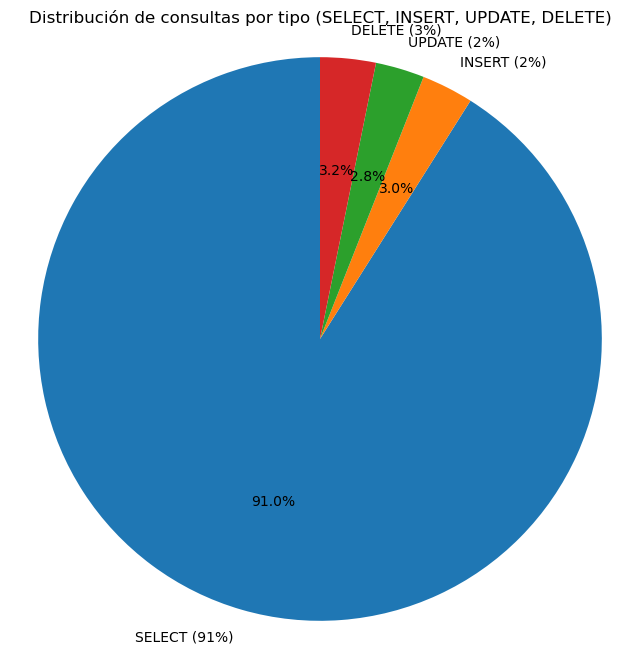

In [10]:
# Definir los strings a buscar
prefixes = ['SELECT', 'INSERT', 'UPDATE', 'DELETE']
# prefixes = [s.lower() for s in prefixes]

# Contar las filas que empiezan con cada uno de los prefijos
counts = {prefix: df['sql'].str.startswith(prefix).sum() for prefix in prefixes}

# Mostrar los resultados
for prefix, count in counts.items():
    print(f"Cantidad de filas que empiezan con {prefix}: {count}")


# Crear el gráfico de tarta
labels = counts.keys()
sizes = counts.values()

# Calcular los porcentajes
total = sum(sizes)
percentages = [size / total * 100 for size in sizes]

# Crear el gráfico de tarta
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=[f"{label} ({int(percentage)}%)" for label, percentage in zip(labels, percentages)], autopct='%1.1f%%', startangle=90)

# Añadir un título
plt.title('Distribución de consultas por tipo (SELECT, INSERT, UPDATE, DELETE)')

# Mostrar el gráfico
plt.axis('equal')  # Para que el gráfico sea un círculo perfecto
plt.show()

In [11]:
# me quedo solo con las consultas que tienen especificamente las clausulas select, from where, order by e group by, sin ninguna otra
import re

# Expresión regular para filtrar las consultas deseadas
pattern = re.compile(
    r"^\s*SELECT\s+.*\s+FROM\s+.*\s+WHERE\s+.*\s*(GROUP BY|ORDER BY)?.*",
    re.IGNORECASE
)

df = df[df['sql'].apply(lambda x: bool(pattern.match(x)))]
df.head()

,sql_prompt,sql,domain,sql_context
21,unique combination security incident type corr...,"SELECT incident, status FROM incident_response...",cybersecurity,CREATE TABLE incident_responses (incident VARC...
27,identify hotel highest virtual tour engagement...,"SELECT hotel_name, q1_2022_views FROM virtual_...",hospitality technology,"CREATE TABLE virtual_tour_stats (hotel_id INT,..."
35,total number security incident occurred region...,"SELECT region, SUM(incidents) as total_inciden...",cybersecurity,"CREATE TABLE incident_region(id INT, region VA..."
41,average age patient received flu shot californ...,"SELECT v.county, AVG(p.age) as avg_age FROM va...",public health,"CREATE TABLE vaccinations (patient_id INT, cou..."
43,number economic diversification initiative tou...,"SELECT category, start_year, COUNT(*), SUM(bud...",rural development,"CREATE TABLE economic_diversification (id INT,..."


In [15]:
df = df[df['sql'].str.startswith('SELECT')]
print(len(df))

10681


In [16]:
df.head()

,sql_prompt,sql,domain,sql_context
21,unique combination security incident type corr...,"SELECT incident, status FROM incident_response...",cybersecurity,CREATE TABLE incident_responses (incident VARC...
27,identify hotel highest virtual tour engagement...,"SELECT hotel_name, q1_2022_views FROM virtual_...",hospitality technology,"CREATE TABLE virtual_tour_stats (hotel_id INT,..."
35,total number security incident occurred region...,"SELECT region, SUM(incidents) as total_inciden...",cybersecurity,"CREATE TABLE incident_region(id INT, region VA..."
41,average age patient received flu shot californ...,"SELECT v.county, AVG(p.age) as avg_age FROM va...",public health,"CREATE TABLE vaccinations (patient_id INT, cou..."
43,number economic diversification initiative tou...,"SELECT category, start_year, COUNT(*), SUM(bud...",rural development,"CREATE TABLE economic_diversification (id INT,..."


In [17]:
# guardo las instrucciones SQL para crear la base de datos
with open("database_script.sql", mode='w+') as f:
  for value in df['sql_context']:
    f.write(str(value) + "\n")

In [18]:
df = df[['sql_prompt', 'sql']]

In [3]:
len(df)

10681

In [3]:
# df.to_csv('results/dataset_text_to_sql.csv', index=False)
df = pd.read_csv('results/dataset_text_to_sql.csv')

In [21]:
df.describe()

,sql_prompt,sql
count,10681,10681
unique,10595,10620
top,average salary employee finance department,SELECT MAX(Salary) FROM Employees WHERE Depart...
freq,3,4


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import GlorotUniform

2025-02-26 21:45:27.042432: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 21:45:27.079780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 21:45:27.079803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 21:45:27.081005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 21:45:27.087644: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# Preparar los datos
input_texts = df['sql_prompt'].values
target_texts = df['sql'].values

# Añadir tokens de inicio y fin a las secuencias de destino
target_texts = [f"<start> {text} <end>" for text in target_texts]

# Tokenización
def tokenize_texts(texts, num_words):
    tokenizer = Tokenizer(num_words=num_words, filters='', lower=False, oov_token='<unk>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    return tokenizer, sequences

# Hiperparámetros
max_vocab_size = 20000
max_input_length = 100
max_target_length = 100

latent_dim = 256  # Tamaño de los vectores latentes
embedding_dim = 100  # Dimensión de los embeddings

# Tokenizar las entradas y salidas
input_tokenizer, input_sequences = tokenize_texts(input_texts, max_vocab_size)
target_tokenizer, target_sequences = tokenize_texts(target_texts, max_vocab_size)

# Obtener longitudes máximas y pad sequences
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
decoder_input_data = pad_sequences([seq[:-1] for seq in target_sequences], maxlen=max_target_length, padding='post')
decoder_target_data = pad_sequences([seq[1:] for seq in target_sequences], maxlen=max_target_length, padding='post')

# Tamanos del vocabulario
num_encoder_tokens = len(input_tokenizer.word_index) + 1
num_decoder_tokens = len(target_tokenizer.word_index) + 1

In [9]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LayerNormalization

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(num_encoder_tokens, 512)(encoder_inputs)
encoder_embedding = LayerNormalization()(encoder_embedding)

# First LSTM (512 units)
encoder_lstm1 = LSTM(512, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.3, 
                     recurrent_regularizer=l2(1e-4), kernel_regularizer=l2(5e-5))
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

# Second LSTM (256 units) - takes the output of the first LSTM
encoder_lstm2 = LSTM(256, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.3, 
                     recurrent_regularizer=l2(1e-4), kernel_regularizer=l2(5e-5))
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

# Encoder states for decoder
encoder_states = [state_h2, state_c2]

# Decoder
decoder_inputs = Input(shape=(max_target_length,))
decoder_embedding = Embedding(num_decoder_tokens, 512)(decoder_inputs)
decoder_embedding = LayerNormalization()(decoder_embedding)

# First LSTM (256 units) - uses encoder layers
decoder_lstm1 = LSTM(256, return_sequences=True, return_state=True, dropout=0.6, recurrent_dropout=0.4, 
                     recurrent_regularizer=l2(1e-4), kernel_regularizer=l2(5e-5))
decoder_outputs1, _, _ = decoder_lstm1(decoder_embedding, initial_state=encoder_states)

# Second LSTM (256 units)
decoder_lstm2 = LSTM(256, return_sequences=True, return_state=True, dropout=0.6, recurrent_dropout=0.4, 
                     recurrent_regularizer=l2(1e-4), kernel_regularizer=l2(5e-5))
decoder_outputs2, _, _ = decoder_lstm2(decoder_outputs1)

# Attention Layer
attention_layer = AdditiveAttention()
attention_outputs = attention_layer([decoder_outputs2, encoder_outputs2])

# Concatenate output of Attention with LSTM output
decoder_combined_context = Concatenate(axis=-1)([attention_outputs, decoder_outputs2])

# Final Dense Layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# Model definition
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
# Entrenamiento
batch_size = 128
epochs = 100

from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.0003, clipnorm=1.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 512)             1688064   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 100, 512)             1024      ['embedding[0][0]']           
 Normalization)                                                                               

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,  # Stop if val_loss doesn't improve for 3 consecutive epochs
    restore_best_weights=True,  # Roll back to the best weights
    verbose=1
)

# Save the best model during training
model_checkpoint = ModelCheckpoint(
    'best_text_to_sql_model.keras', 
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)

model_checkpoint_h5 = ModelCheckpoint(
    'best_text_to_sql_model.h5', 
    monitor='val_loss', 
    save_best_only=True,
    save_format='h5',
    verbose=1
)

# Reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  # Reduce the learning rate by half
    patience=2,  # Wait for 2 epochs without improvement
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

# Combine callbacks
callbacks = [early_stopping, model_checkpoint, model_checkpoint_h5, reduce_lr]

from tensorflow.keras.callbacks import Callback

class SaveTokenizersCallback(Callback):
    def __init__(self, input_tokenizer, target_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.target_tokenizer = target_tokenizer
        
    def on_epoch_end(self, epoch, logs=None):
        # Save tokenizers at the end of each epoch
        input_tokenizer_filename = f'tokenizers/input_tokenizer_epoch_{epoch + 1}.json'
        target_tokenizer_filename = f'tokenizers/target_tokenizer_epoch_{epoch + 1}.json'

        with open(input_tokenizer_filename, 'w') as f:
            f.write(self.input_tokenizer.to_json())

        with open(target_tokenizer_filename, 'w') as f:
            f.write(self.target_tokenizer.to_json())

        print(f"Tokenizers saved for epoch {epoch + 1}!")

    # def on_train_end(self, logs=None):
    #     # Save tokenizers when training ends
    #     save_tokenizer(self.input_tokenizer, 'input_tokenizer.json')
    #     save_tokenizer(self.target_tokenizer, 'target_tokenizer.json')
    #     print("Tokenizers saved successfully!")

save_tokenizers_callback = SaveTokenizersCallback(input_tokenizer, target_tokenizer)
callbacks.append(save_tokenizers_callback)

class CustomEarlyStopping(Callback):
    def __init__(self, threshold=0.2):
        super(CustomEarlyStopping, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss <= self.threshold:
            print(f"\nStopping early as val_loss reached {val_loss:.4f}, which is below the threshold of {self.threshold:.4f}.")
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping(threshold=0.5)

# Add the callback to the list
callbacks.append(custom_early_stopping)

In [ ]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/100


2025-02-26 09:09:55.093937: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1310720000 exceeds 10% of free system memory.
2025-02-26 09:09:56.141574: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1310720000 exceeds 10% of free system memory.
2025-02-26 09:09:57.265336: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1011865600 exceeds 10% of free system memory.
2025-02-26 09:09:59.689533: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1011865600 exceeds 10% of free system memory.
2025-02-26 09:09:59.689670: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1011865600 exceeds 10% of free system memory.


67/67 [==============================] - ETA: 0s - loss: 3.6546 - accuracy: 0.8178 
Epoch 1: val_loss improved from inf to 1.25413, saving model to best_text_to_sql_model.keras

Epoch 1: val_loss improved from inf to 1.25413, saving model to best_text_to_sql_model.h5


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Tokenizers saved for epoch 1!
67/67 [==============================] - 1957s 29s/step - loss: 3.6546 - accuracy: 0.8178 - val_loss: 1.2541 - val_accuracy: 0.8322 - lr: 3.0000e-04
Epoch 2/100
 7/67 [==>...........................] - ETA: 43:30 - loss: 1.1705 - accuracy: 0.8560

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model = load_model('best_text_to_sql_model.keras')
model.summary()

In [7]:
# continuar desde una epoca
epoca = 20

# Load dependencies
from tensorflow.keras.models import load_model
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import numpy as np

# Load the trained model from epoch 11
model = load_model('best_text_to_sql_model.keras')

# Load the input tokenizer
with open(f'tokenizers/input_tokenizer_epoch_{epoca}.json', 'r') as f:
    input_tokenizer_config = json.load(f)
input_tokenizer = tokenizer_from_json(json.dumps(input_tokenizer_config))

# Load the target tokenizer
with open(f'tokenizers/target_tokenizer_epoch_{epoca}.json', 'r') as f:
    target_tokenizer_config = json.load(f)
target_tokenizer = tokenizer_from_json(json.dumps(target_tokenizer_config))

# Ensure all training parameters are set
batch_size = 128
epochs = 100  # This should be the final total epochs
initial_epoch = epoca  # Continue training from epoch

# Train the model from a given epoch onward
history = model.fit(
    [encoder_input_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=batch_size,
    epochs=epochs,  # Total epochs (e.g., 100)
    initial_epoch=initial_epoch,
    validation_split=0.2,
    callbacks=callbacks  # Ensure callbacks like ModelCheckpoint are defined
)

Epoch 21/100
67/67 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.9256 
Epoch 21: val_loss improved from 0.62306 to 0.61508, saving model to best_text_to_sql_model.keras

Epoch 21: val_loss improved from 0.62306 to 0.61508, saving model to best_text_to_sql_model.h5
Tokenizers saved for epoch 21!
67/67 [==============================] - 1277s 19s/step - loss: 0.4446 - accuracy: 0.9256 - val_loss: 0.6151 - val_accuracy: 0.9182 - lr: 3.0000e-04
Epoch 22/100
 6/67 [=>............................] - ETA: 17:30 - loss: 0.4377 - accuracy: 0.9248

KeyboardInterrupt: 

# Probando el modelo

In [4]:
model = load_model('best_text_to_sql_model.keras')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 100, 512)             1688064   ['input_7[0][0]']             
                                                                                                  
 input_8 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 layer_normalization_6 (Lay  (None, 100, 512)             1024      ['embedding_6[0][0]']         
 erNormalization)                                                                           

In [8]:
# Load the model
from tensorflow.keras.models import load_model
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json

model = load_model('best_text_to_sql_model.keras')

# Load the input tokenizer
with open('tokenizers/input_tokenizer_epoch_21.json', 'r') as f:
    input_tokenizer_config = json.load(f)
input_tokenizer = tokenizer_from_json(json.dumps(input_tokenizer_config))

# Load the target tokenizer
with open('tokenizers/target_tokenizer_epoch_21.json', 'r') as f:
    target_tokenizer_config = json.load(f)
target_tokenizer = tokenizer_from_json(json.dumps(target_tokenizer_config))

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Define encoder inputs
encoder_inputs = model.get_layer("input_7").input
encoder_embedding = model.get_layer("embedding_6")(encoder_inputs)
encoder_norm = model.get_layer("layer_normalization_6")(encoder_embedding)

# LSTM layers
encoder_lstm1 = model.get_layer("lstm_11")
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_norm)

encoder_lstm2 = model.get_layer("lstm_12")
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)  # This is the final output

# Define encoder model (ensure it returns 3 values)
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs2, state_h2, state_c2])

print("✅ Encoder model successfully extracted!")

✅ Encoder model successfully extracted!


In [10]:
from tensorflow.keras.layers import LSTM, AdditiveAttention, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Decoder inputs
decoder_inputs = model.get_layer("input_8").input
decoder_embedding = model.get_layer("embedding_7")(decoder_inputs)
decoder_norm = model.get_layer("layer_normalization_7")(decoder_embedding)

# Decoder LSTMs with states from the encoder
decoder_lstm1 = model.get_layer("lstm_13")
decoder_lstm2 = model.get_layer("lstm_14")

# Define decoder initial states (received from the encoder during inference)
decoder_state_input_h1 = Input(shape=(256,))
decoder_state_input_c1 = Input(shape=(256,))
decoder_state_input_h2 = Input(shape=(256,))
decoder_state_input_c2 = Input(shape=(256,))

decoder_outputs1, state_h1, state_c1 = decoder_lstm1(
    decoder_norm, initial_state=[decoder_state_input_h1, decoder_state_input_c1]
)
decoder_outputs2, state_h2, state_c2 = decoder_lstm2(
    decoder_outputs1, initial_state=[decoder_state_input_h2, decoder_state_input_c2]
)

# Attention mechanism (use `lstm_12` output instead of `encoder_lstm1`)
attention_layer = model.get_layer("additive_attention_2")
encoder_outputs = Input(shape=(100, 256))  # Corrected to match decoder_outputs2
attention_output = attention_layer([decoder_outputs2, encoder_outputs])

# Concatenation and final dense layer
concatenated = Concatenate()([attention_output, decoder_outputs2])
decoder_dense = model.get_layer("dense_1")
decoder_outputs = decoder_dense(concatenated)

# Decoder model
decoder_model = Model(
    [decoder_inputs, decoder_state_input_h1, decoder_state_input_c1, decoder_state_input_h2, decoder_state_input_c2, encoder_outputs],
    [decoder_outputs, state_h1, state_c1, state_h2, state_c2]
)
print("✅ Decoder model successfully extracted!")

✅ Decoder model successfully extracted!


In [19]:
import numpy as np

def decode_sequence(input_seq, encoder_model, decoder_model, target_tokenizer, max_target_length):
    """Generate SQL query from a natural language input."""
    # Get encoder outputs and states
    encoder_outputs, state_h1, state_c1 = encoder_model.predict(input_seq)

    # Start token ID
    start_token = target_tokenizer.word_index['<start>']
    end_token = target_tokenizer.word_index['<end>']

    # Initial decoder input (start token)
    target_seq = np.array([[start_token]])

    # Initialize decoder states (use both LSTM layers' states)
    state_h2, state_c2 = state_h1, state_c1  # Assuming the second layer starts with same states

    decoded_sentence = []

    for _ in range(max_target_length):
        # Predict next token with all 6 required inputs
        decoder_inputs = [target_seq, state_h1, state_c1, state_h2, state_c2, encoder_outputs]
        predictions, state_h1, state_c1, state_h2, state_c2 = decoder_model.predict(decoder_inputs)

        # Get most probable word index
        sampled_token_index = np.argmax(predictions[0, -1, :])
        sampled_word = target_tokenizer.index_word.get(sampled_token_index, '<unk>')

        if sampled_word == '<end>':
            break

        decoded_sentence.append(sampled_word)

        # Update target sequence with the new predicted token
        target_seq = np.array([[sampled_token_index]])
    
    return ' '.join(decoded_sentence)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_input_text(text, tokenizer, max_length):
    """Tokenize and pad the input natural language text."""
    # Convert the text to sequence using the tokenizer
    sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence to the expected input length
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    return padded_sequence

In [33]:
input_nl_query = "List the names with nationality USA"

In [34]:
# Convertimos a minúsculas
input_nl_query = input_nl_query.lower()
# df['sql'] = df['sql'].map(lambda x: x.lower())

import re
import string

# Función para eliminar signos de puntuación
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la función al dataset
input_nl_query = eliminar_signos(input_nl_query)

In [35]:
custom_stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(texto):
    words = []
    for word in texto.split():
        if word not in custom_stop_words:
            word_lemma = lemmatizer.lemmatize(word)
            words.append(word_lemma)
    return ' '.join(words)

# Apply the function
input_nl_query = clean_text(input_nl_query)

In [36]:
max_input_length = 100
max_target_length = 100

# Example natural language input
# input_nl_query = "list all missions with astronauts from US"
# input_nl_query = "identify hotel highest virtual tour engagement in apac region in q1 2022"

# Tokenize input text
input_seq = preprocess_input_text(input_nl_query, input_tokenizer, max_input_length)

# Generate SQL
result_sql = decode_sequence(input_seq, encoder_model, decoder_model, target_tokenizer, max_target_length)

print("Generated SQL:", result_sql)

1/1 [==============================] - 0s 20ms/step
Generated SQL: SELECT name SELECT name FROM players WHERE Country = 'USA';
